In [ ]:
!unzip /content/drive/MyDrive/semeval_task_5.zip
! mv /content/semeval_task_5/InteractiveAttention.py /content
! mv /content/semeval_task_5/img_features.pkl /content
! mv /content/semeval_task_5/TRAINING /content

In [1]:
!pip install transformers

In [2]:
!pip install tensorflow_addons

In [4]:
!cat /proc/meminfo | grep MemTotal

MemTotal:       26696420 kB


In [5]:
!nvidia-smi

Sun Feb 20 08:01:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

(9000, 128)
(1000, 128)
128
768
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet101v2 (Functional)       (None, 2048)         42626560    ['input_1[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
563/563 [==============================] - 279s 439ms/step - loss: 0.2801 - mae: 0.3482 - acc: 0.7272 - f1_score: 0.2177 - val_loss: 0.2246 - val_mae: 0.3430 - val_acc: 1.0000 - val_f1_score: 0.2660
Epoch 2/20
563/563 [==============================] - 243s 432ms/step - loss: 0.2239 - mae: 0.3299 - acc: 0.8130 - f1_score: 0.3122 - val_loss: 0.2298 - val_mae: 0.3304 - val_acc: 0.9680 - val_f1_score: 0.3019
Epoch 3/20
563/563 [==============================] - 243s 432ms/step - loss: 0.1899 - mae: 0.3037 - acc: 0.7957 - f1_score: 0.4162 - val_loss: 0.2342 - val_mae: 0.3247 - val_acc: 0.7880 - val_f1_score: 0.3552
Epoch 4/20
563/563 [==============================] - 243s 432ms/step - loss: 0.1557 - mae: 0.2662 - acc: 0.7503 - f1_score: 0.5448 - val_loss: 0.3038 - val_mae: 0.2903 - val_acc: 0.6230 - val_f1_score: 0.3511
Epoch 5/20
563/563 [==============================] - 243s 432ms/step - loss: 0.1314 - mae: 0.2354 - acc: 0.7122 - f1_score: 0.6586 - val_loss: 0.4219 - val_mae

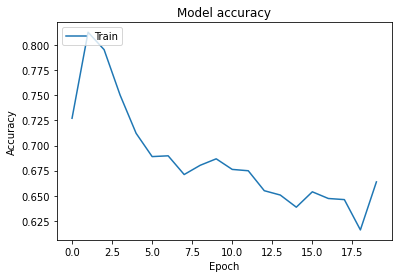

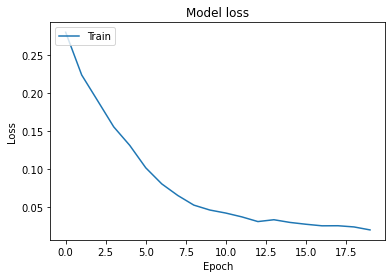

In [3]:
from transformers import ElectraTokenizerFast, ElectraConfig
from transformers.models.electra.modeling_tf_electra import TFElectraMainLayer
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import cv2 as cv

batch_size  = 16
epochs = 20
num_labels = 5


if __name__ == '__main__':
    class InteractiveAttention(tf.keras.layers.Layer):
        def __init__(self, input_dim=768, input_len=768):
            super(InteractiveAttention, self).__init__()
            self.w = self.add_weight(
                shape=(input_dim, input_len),
                initializer="random_normal",
                trainable=True,
                name='w'
            )

        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'w': self.w.numpy()
            })
            return config

        def call(self, h_former, h_latter):
            x = tf.matmul(h_former, self.w)  # 矩阵相乘
            return tf.multiply(x, h_latter)  # 对应元素


    data_path = os.path.join('TRAINING/training.csv')
    train_df = pd.read_csv(data_path, sep=',')
    # %%
    train_images, train_texts, train_labels = [], [], []
    val_images, val_texts = [], []
    classification = ['misogynous', 'shaming', 'stereotype', 'objectification', 'violence']  # labels of the dataset

    for i, identity in enumerate(train_df['file_name']):
        # load image
        image = cv.imread(os.path.join('TRAINING', str(identity) + '.jpg'))
        resized_image = cv.resize(image, (224, 224)) / 255.
        train_images.append(resized_image)
        # if i == 0:
        #     cv.namedWindow("Image")
        #     cv.imshow("Image", image)
        #     cv.waitKey(0)
        #     cv.destroyAllWindows()
        # load text
        train_texts.append(train_df['Text Transcription'][i])
        # load labels
        emotion_class = np.zeros(5)
        for j, emotion in enumerate(classification):
            if train_df[emotion][i] == 1:
                emotion_class[j] = 1
        train_labels.append(emotion_class.tolist())

    # %%
    train_images,val_images,train_texts, val_texts, train_labels, val_labels = \
    train_test_split(train_images, train_texts, train_labels, random_state=10, test_size=0.1)
    train_images = np.array(train_images, dtype='float32')
    val_images = np.array(val_images, dtype='float32')
    tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-base-discriminator')
    train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=128)

    val_encodings = tokenizer(val_texts, truncation=True, padding='max_length', max_length=128)
    print(np.array(train_encodings['input_ids']).shape)
    print(np.array(val_encodings['input_ids']).shape)

    train_dataset = tf.data.Dataset.from_tensor_slices((
        {'input_images': train_images, 'input_ids': train_encodings['input_ids'],
         'token_type_ids': train_encodings['token_type_ids'],
         'attention_mask': train_encodings['attention_mask']},
        train_labels
    ))

    val_dataset = tf.data.Dataset.from_tensor_slices((
        {'input_images': val_images, 'input_ids': val_encodings['input_ids'],
         'token_type_ids': val_encodings['token_type_ids'],
         'attention_mask': val_encodings['attention_mask']},
        val_labels
    ))

    # %%
    config = ElectraConfig.from_pretrained('google/electra-base-discriminator', max_position_embeddings=128)
    print(config.max_position_embeddings)
    input_images = tf.keras.Input(shape=(224, 224, 3))
    resnet = tf.keras.applications.resnet_v2.ResNet101V2(weights='imagenet', include_top=False, pooling='max')
    image_features = resnet(input_images)
    image_features = tf.keras.layers.Flatten()(image_features)
    image_features = tf.keras.layers.Dense(1024, activation='relu')(image_features)
    input_ids = tf.keras.Input(shape=(config.max_position_embeddings,), dtype='int32')
    token_type_ids = tf.keras.Input(shape=(config.max_position_embeddings,), dtype='int32')
    attention_mask = tf.keras.Input(shape=(config.max_position_embeddings,), dtype='int32')

    bert_layer = TFElectraMainLayer(config=config)
    inputs = {'input_images': input_images,'input_ids': input_ids, 'token_type_ids': token_type_ids,
              'attention_mask': attention_mask}
    bert_features = bert_layer(inputs)[0][:, 0, :]

    print(bert_features.shape[-1])
    concate = InteractiveAttention(input_dim=image_features.shape[-1], input_len=bert_features.shape[-1])(image_features,
                                                                                                        bert_features)
    layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(concate)
    dropout_output = tf.keras.layers.Dropout(config.hidden_dropout_prob)(layernorm)

    output = tf.keras.layers.Dense(num_labels, activation='sigmoid',
                                   kernel_initializer=tf.keras.initializers.TruncatedNormal(config.initializer_range))(
        dropout_output)

    model = tf.keras.Model(inputs=inputs, outputs=output)

    print(model.summary())
    optimizer = tf.keras.optimizers.Adam(lr=5e-5, epsilon=1e-8)
    loss = tfa.losses.SigmoidFocalCrossEntropy(
        from_logits=False,
        alpha=0.25,
        gamma=2.0,
        name='sigmoid_focal_crossentropy'
    )
    # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    #     'Checkpoint_tra_30epochs_nordrop_taditional/' + 'weights.{epoch:02d}.hdf5',
    #     monitor='mae', verbose=1,
    #     save_best_only=True,
    #     save_weights_only=False, mode='min')
    f1score = tfa.metrics.F1Score(num_classes=5, threshold=0.5,average='weighted')
    model.compile(optimizer=optimizer, loss=loss, metrics=['mae', 'acc',f1score])
    history = model.fit(train_dataset.shuffle(1000).batch(batch_size),validation_data=val_dataset.batch(batch_size),
                        epochs=epochs)
    from matplotlib import pyplot as plt

    plt.plot(history.history['acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    # 绘制训练 & 验证的损失值
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()

In [ ]:
f1score_ = history.history['f1_score']

In [ ]:
print(val_labels)

[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 1.0, 1.0, 0.0], [1.0, 0.0, 1.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 1.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], 